# Average number of bikes per hour and per day

This notebooks calculates the average number of bikes per hour and per day for each station to be predicted. It then predicts the number of expected bikes for the test set by using a nested lookup table where the keys are the days and the hours. This method scored 3.947.

## Data loading

In [1]:
import pandas as pd

def get_station_updates(city, station):
    df = pd.read_csv('challenge_data/part_1/{}/stations/{}.csv'.format(city, station))
    df['moment'] = pd.to_datetime(df['moment'])
    return df

## Fit

In [2]:
def mean_bikes_per_day_per_hour(city, station):
    df = get_station_updates(city, station)
    df['weekday'] = df['moment'].map(lambda x: x.weekday())
    df['hour'] = df['moment'].map(lambda x: x.hour)
    means = {
        weekday: {
            hour: group2['bikes'].mean()
            for hour, group2 in group1.groupby('hour')
        }
        for weekday, group1 in df.groupby('weekday')
    }
    return means

The lookup table can be visualized with a heatmap. In the following heatmap, each row indicates an hour and each column represents a day. The cells are "warmer" the more bikes there during that hour and day.

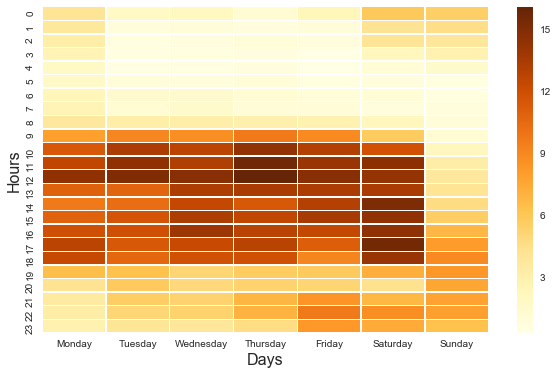

In [3]:
import calendar
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

lookup_table = mean_bikes_per_day_per_hour('toulouse', '00003-pomme')
hm = pd.DataFrame.from_dict(lookup_table, orient='index').T
hm.columns = [calendar.day_name[col] for col in hm.columns]

plt.figure(figsize=(10, 6))
sns.heatmap(hm, linewidths=.4, cmap='YlOrBr')
plt.xlabel('Days', fontsize=16)
plt.ylabel('Hours', fontsize=16)

## Predict

In [4]:
to_predict_df = pd.read_csv('challenge_data/part_1/test-blank.csv', index_col=0)
to_predict_df['moment'] = pd.to_datetime(to_predict_df.index)
to_predict_df['weekday'] = to_predict_df['moment'].map(lambda t: t.weekday())
to_predict_df['hour'] = to_predict_df['moment'].map(lambda t: t.hour)

Build a dictionary with the name of the cities and the stations to predict.

In [5]:
means = {
    city_name: {
        station_name: mean_bikes_per_day_per_hour(city_name, station_name)
        for station_name in rows['station'].unique()
    }
    for city_name, rows in to_predict_df.groupby('city')
}

For each row in the test set, get the average number of bikes from the lookup table.

In [6]:
to_predict_df['bikes'] = to_predict_df.apply(lambda r: means[r['city']][r['station']][r['weekday']][r['hour']], axis=1).tolist()

Delete the columns that are not necessary for submitting.

In [7]:
to_predict_df.drop('moment', axis=1, inplace=True)
to_predict_df.drop('weekday', axis=1, inplace=True)
to_predict_df.drop('hour', axis=1, inplace=True)